In [4]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tensorflow.keras.datasets as datasets
from torch_dataload import MyDataset
import nn_fuzzy
import matplotlib.pyplot as plt
import time
import math

In [19]:
import numpy as np

def pi_membership_function(r,c,radius):
    norm = abs(r-c)
    if radius == 0:
        return np.zeros(norm.shape)
    else:
        for i in range(len(r)):
            if norm[i] <= radius and norm[i] >= radius/2:
                norm[i] = (2*((1-norm[i]/radius)**2))
#                 print("Case 1")
            elif norm[i] < radius/2 and norm[i] >= 0:
                norm[i] = (1 - 2*((norm[i]/radius)**2))
#                 print("Case 2")
            else:
                norm[i] = 0
#                 print("Case 3")
    return norm

def input_fuzzy_features(x_train, iid = 1):
    fdenom = 2
    if iid == 1:
        F_max = np.array([255]*784)
        F_min = np.array([0]*784)
    else:
        F_max = np.ndarray.max(x_train, axis = 0)
        F_min = np.ndarray.min(x_train, axis = 0)
    lambda_medium = 0.5*(F_max - F_min)
    c_medium = F_min + lambda_medium
    print(c_medium)
    lambda_low = (1/fdenom)*(c_medium-F_min)
    print(lambda_low)
    c_low = c_medium - 0.5 * lambda_low
    print(c_low)
    lambda_high = (1/fdenom) * (F_max - c_medium)
    print(lambda_high)
    c_high = c_medium + 0.5 * lambda_high
    print(c_high)
    input_features = {
        'lambda_low': lambda_low,
        'lambda_medium': lambda_medium,
        'lambda_high': lambda_high,
        'c_low': c_low,
        'c_medium': c_medium,
        'c_high': c_high
    }
    return input_features
def fuzzy_input_single(x_train, input_features, iid = 1, cnn = 0):
    if iid == 1:
        F_max = np.array([255]*784)
        F_min = np.array([0]*784)
    else:
        F_max = np.ndarray.max(x_train, axis = 0)
        F_min = np.ndarray.min(x_train, axis = 0)
    lambda_low = input_features['lambda_low']
    lambda_medium = input_features['lambda_medium']
    lambda_high = input_features['lambda_high']
    c_low = input_features['c_low']
    c_medium = input_features['c_medium']
    c_high = input_features['c_high']
    x_train = x_train.T
#     print(x_train)
    if cnn == 1:
        x_train_low = []
        x_train_medium = []
        x_train_high = []
        for i in range(len(F_max)):
            x_train_low.append(pi_membership_function(x_train[i],c_low[i],lambda_low[i]))
            x_train_medium.append(pi_membership_function(x_train[i],c_medium[i],lambda_medium[i]))
            x_train_high.append(pi_membership_function(x_train[i],c_high[i],lambda_high[i]))
        x_train_new = np.stack([x_train_low, x_train_medium, x_train_high], axis = 1)
        return np.array(x_train_new)
    else:
        x_train_new = []
        for i in range(len(F_max)):
            x_train_new.append(pi_membership_function(x_train[i],c_low[i],lambda_low[i]))
            x_train_new.append(pi_membership_function(x_train[i],c_medium[i],lambda_medium[i]))
            x_train_new.append(pi_membership_function(x_train[i],c_high[i],lambda_high[i]))
        return np.array(x_train_new)
def output_normalize(x_train, y_train):
    shape  = y_train.shape[1]
    mean = np.zeros((shape,x_train.shape[1]))
    standard_deviation = np.zeros((shape, x_train.shape[1]))
    no_of_belongings = np.zeros(shape)
    for i in range(x_train.shape[0]):
        for j in range(y_train.shape[1]):
            if(y_train[i][j]==1):
                no_of_belongings[j] = no_of_belongings[j]+1
                mean[j]= mean[j]+x_train[i]

    print(mean.shape)
    # print(mean[0][0:100])
    for j in range(y_train.shape[1]):
        mean[j] = mean[j]/no_of_belongings[j]
        # print(no_of_belongings[j])

    # print(mean.shape)
    # print(k)
    # print(mean[0][0:100])
    for i in range(x_train.shape[0]):
        for j in range(y_train.shape[1]):
            if(y_train[i][j]==1):
                k = x_train[i] - mean[j]
                k = np.square(k)
                standard_deviation[j] = standard_deviation[j]+k

    for j in range(y_train.shape[1]):
        standard_deviation[j] = standard_deviation[j]/(no_of_belongings[j] - 1)
        for i in range(len(standard_deviation[j])):
            if standard_deviation[j][i] == 0:
                standard_deviation[j][i] = 1
            
    standard_deviation = np.sqrt(standard_deviation)
    print(standard_deviation.shape)
    weighted_distance = np.zeros((x_train.shape[0],shape))
    for i in range(x_train.shape[0]):
        for j in range(y_train.shape[1]):  #10
            weighted_distance[i][j] = math.sqrt(np.sum(np.square(np.divide(x_train[i] - mean[j],standard_deviation[j]))))
    return weighted_distance, mean
def output_membership_function(n_class, pattern):
    # out is an array on n_class dimension, containing membership of a feature vector to each class
    denom_generator = 5
    expo_generator = 2
    out = pattern / denom_generator
    out = np.power(out, expo_generator)
    out = np.reciprocal(1 + out)
    return out

def membership_enhancement(membership):
    if membership < 0.5:
        enhc = 2 * np.power(membership, 2)
    else:
        enhc = 1 - np.power(1-membership, 2)
    return enhc
        
def output_fuzzify(x_train, y_train):
    #Normalize the output fot class membership
    weighted_distance, _ = output_normalize(x_train, y_train)
    #Get class memberships for each input pattern
    membership = output_membership_function(10, weighted_distance)
    #Enhance the membership values if needed (the membership values are too fuzzified)
    enhanced_membership = (membership)
    return enhanced_membership

"""Fuzzification"""
def fuzzify_dataset(x_train, x_test, y_train, y_test, iid = 0, cnn = 0):
    start = time.time()
    x_train_fuzzy = np.array([])
    input_features = input_fuzzy_features(x_train, iid)
    x_train_fuzzy = fuzzy_input_single(x_train, input_features, iid, cnn)
    end = time.time()
    print("Time taken to fuzzify - x_train :", end = ' ')
    print(end-start)
    start = time.time()
    x_test_fuzzy = np.array([])
    input_features = input_fuzzy_features(x_test, iid)
    x_train_fuzzy = fuzzy_input_single(x_test, input_features, iid, cnn)
    end = time.time()
    print("Time taken to fuzzify - x_test :", end = ' ')
    print(end-start)
    start = time.time()
    y_train_fuzzy = output_fuzzify(x_train, y_train)
    end = time.time()
    print("Time taken to fuzzify - y_train :", end = ' ')
    print(end-start)
    start = time.time()
    y_test_fuzzy = y_test
    end = time.time()
    print("Time taken to fuzzify - y_train :", end = ' ')
    print(end-start)
    return x_train_fuzzy.T, x_test_fuzzy.T, y_train_fuzzy, y_test_fuzzy

In [20]:
def getDataset(name, nClass):
    if name=="mnist":
        dataset = datasets.mnist
    (x_train, y_train),(x_test, y_test) = dataset.load_data()     #downloading and loading the dataset
    x_train, x_test = x_train, x_test            #normalizing the input data
    x_train_flat = x_train.reshape(x_train.shape[0],-1)         #making dataset suitable for input in Fully Connected layer
    x_test_flat = x_test.reshape(x_test.shape[0],-1)          #making dataset suitable for input in Fully Connected layer
    y_train_onehot = np.eye(nClass)[y_train]                    #converting to one hot vectors
    y_test_onehot = np.eye(nClass)[y_test]                     #converting to one hot vectors
    print(x_train_flat.shape)
    print(y_train_onehot.shape)
    x_train_batch = np.array_split(x_train_flat, int(60000/128))
    print(x_train_batch[2].shape)
    return x_train_flat,x_test_flat,y_train_onehot,y_test_onehot

x_train, x_test, y_train, y_test = getDataset("mnist", 10)

(60000, 784)
(60000, 10)
(129, 784)


In [21]:
x_train_fuzzy, x_test_fuzzy, y_train_fuzzy, y_test_fuzzy = fuzzify_dataset(x_train[:100], x_test[:100], y_train, y_test, cnn=1)

[  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    2.5  67.
 127.5 112.5 112.5 112.5  45.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    4.   39.
  78.  104.5  95.5 123.  127.5 127.5 127.5 126.5  30.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.   58.   78.5 126.  126.  127.5 127.5 127.5 127.5 127.5 127.5 127.5
 122.   57.   94.5  95.    0.    0.    0.    0.    0.    0.    0.    6.5
  49.5  45.5  94.5 127.  127.5 127.  127.  127.  127.5 127.5 127.5 127.5
 127.5 127.5 127.5 127.5 127.5 127.5 123.5  76.5   0.    0.  

[  0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.     47.5   108.75  141.25  159.375 158.75   58.125   8.75
  88.125 140.     49.375   0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.    138.75  159.375 135.625 158.125 159.375 159.375
 152.5   158.125 158.125 154.375  81.25    0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      7.5    29.375  91.25  150.625 159.375 159.375 158.75  158.75
 159.375 159.

In [22]:
x_train_fuzzy = x_train_fuzzy.reshape(-1, 3, 28, 28)
x_test_fuzzy = x_test_fuzzy.reshape(-1, 3, 28, 28)

array([3.14397892e-05, 1.17090374e-05, 2.92217942e-05, 3.17234884e-05,
       7.44164663e-02, 1.29360465e-05, 1.60612282e-05, 1.55863170e-05,
       1.52805015e-05, 2.19573517e-05])

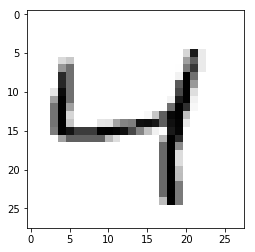

In [29]:
index = 2
plt.imshow(x_train[index].reshape(28,28), cmap='Greys')
y_train_fuzzy[index]

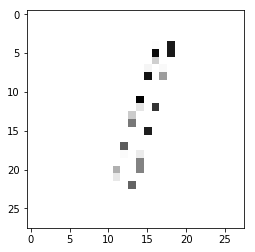

In [30]:
plt.imshow(x_train_fuzzy[index][0].reshape(28,28), cmap='Greys')

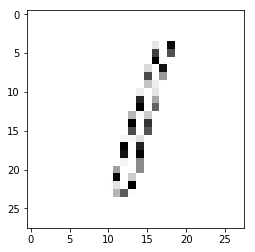

In [31]:
plt.imshow(x_train_fuzzy[index][1].reshape(28,28), cmap='Greys')

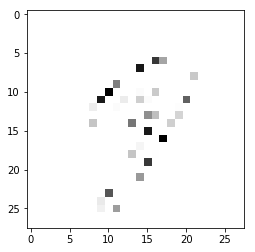

In [26]:
plt.imshow(x_train_fuzzy[index][2].reshape(28,28), cmap='Greys')